In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import Metric, Precision, Recall
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False)

# Load labels
labels_df = pd.read_csv('/kaggle/input/amazonsatelliteimages/train_v2.csv/train_v2.csv')


94765736/94765736 [==============================] - 0s 0us/step


In [4]:
# Create binary labels for 'habitation' and 'slash_burn'
labels_df['deforestation'] = labels_df['tags'].apply(lambda x: 1 if 'habitation' in x else 0)
labels_df['pollution'] = labels_df['tags'].apply(lambda x: 1 if 'slash_burn' in x else 0)


In [5]:
# Split dataset into training and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=42)


In [6]:
# Add file extensions to image filenames
train_df['image_name'] = train_df['image_name'].apply(lambda x: f"{x}.jpg")
val_df['image_name'] = val_df['image_name'].apply(lambda x: f"{x}.jpg")


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to create generator for the dataset
def create_dataset_generator(df, data_dir, batch_size=32, target_size=(224, 224)):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        df, directory=data_dir, x_col='image_name', y_col=['deforestation', 'pollution'],
        target_size=target_size, batch_size=batch_size, class_mode='raw')
    return generator

# Set the path to dataset directory
data_dir = '/kaggle/input/amazonsatelliteimages/train-jpg/train-jpg'

# Create dataset generators for training and validation sets
train_generator = create_dataset_generator(train_df, data_dir)
val_generator = create_dataset_generator(val_df, data_dir)



Found 32383 validated image filenames.
Found 8096 validated image filenames.


In [8]:
from tensorflow.keras.layers import Dropout

# Add dropout layers to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)


In [9]:
# Freeze the base_model layers
for layer in base_model.layers:
    layer.trainable = False


# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])



In [10]:
# Train the model
history = model.fit(train_generator, epochs=3, validation_data=val_generator)


Epoch 1/3
1012/1012 [==============================] - 379s 363ms/step - loss: 0.1736 - auc: 0.7596 - val_loss: 0.1596 - val_auc: 0.8785
Epoch 2/3
1012/1012 [==============================] - 141s 139ms/step - loss: 0.1582 - auc: 0.8095 - val_loss: 0.1536 - val_auc: 0.8802
Epoch 3/3
1012/1012 [==============================] - 142s 140ms/step - loss: 0.1529 - auc: 0.8317 - val_loss: 0.1487 - val_auc: 0.8848


In [11]:
from tensorflow.keras.preprocessing import image

def predict_deforestation_pollution(model, img_path, img_size=(224, 224)):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    # Make a prediction using model
    preds = model.predict(x)

    return preds


1/1 [==============================] - 1s 1s/step


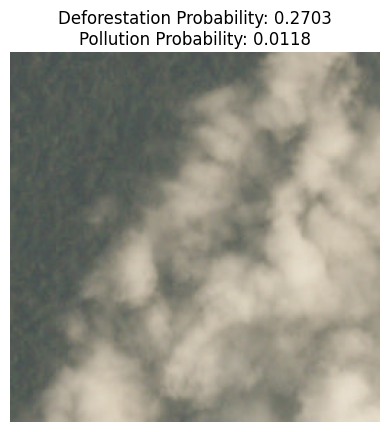

1/1 [==============================] - 0s 32ms/step


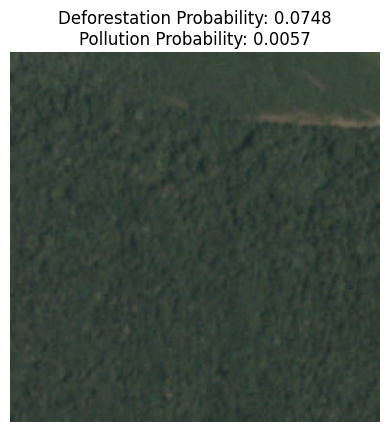

1/1 [==============================] - 0s 31ms/step


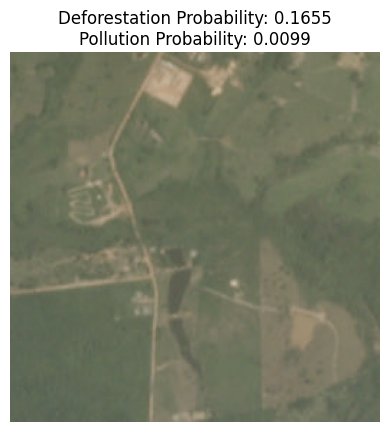

1/1 [==============================] - 0s 32ms/step


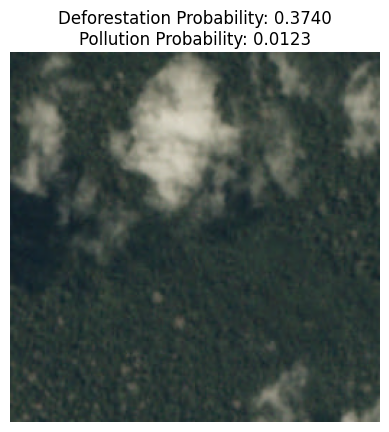

1/1 [==============================] - 0s 30ms/step


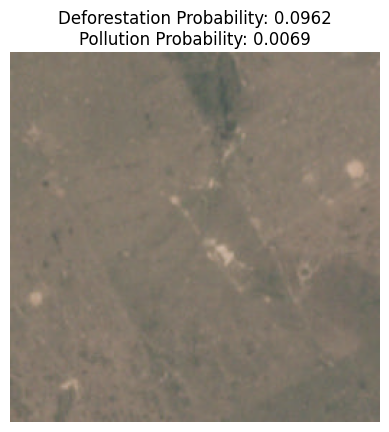

In [12]:
import os
import random
import matplotlib.pyplot as plt

def display_image_with_predictions(img_path, deforestation_prob, pollution_prob):
    img = image.load_img(img_path)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Deforestation Probability: {deforestation_prob:.4f}\nPollution Probability: {pollution_prob:.4f}")
    plt.axis("off")
    plt.show()

# Set path to the test dataset directory
test_data_dir = '/kaggle/input/amazonsatelliteimages/test-jpg/test-jpg'

# Choose a few random images from test dataset
test_images = random.sample(os.listdir(test_data_dir), 5)

# Evaluate model's performance on selected test images
for img_name in test_images:
    img_path = os.path.join(test_data_dir, img_name)
    preds = predict_deforestation_pollution(model, img_path)

    deforestation_prob = preds[0][0]
    pollution_prob = preds[0][1]

    display_image_with_predictions(img_path, deforestation_prob, pollution_prob)
